In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbs
import re
import scipy.stats as ss
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)

In [3]:
gracia_raw = pd.read_csv("data/gracia.csv", names=["title", "url", "price_str", "details","description"])
raval_raw = pd.read_csv("data/raval.csv", names=["title", "url", "price_str", "details","description"])
sants_raw = pd.read_csv("data/sants.csv", names=["title", "url", "price_str", "details","description"])
gracia_raw["district"] = "gracia"
raval_raw["district"] = "raval"
sants_raw["district"] = "sants"
all_raw = pd.concat([gracia_raw, raval_raw, sants_raw])
all_raw.head()

,title,url,price_str,details,description,district
0,"Piso en calle de Sant Joaquim, Vila de Gràcia,...",/inmueble/86583453/,1.090€/mes,"2 hab.,74 m²,5ª planta exterior sin ascensor,1...",Piso ubicado a escasos metros de Plaça de la...,gracia
1,"Piso en GRAN DE GRACIA, 160, Vila de Gràcia, B...",/inmueble/35350408/,1.250€/mes,"2 hab.,77 m²,1ª planta exterior sin ascensor","Fantástico piso en plantaprincipal, de 77 m2...",gracia
2,"Ático en Vila de Gràcia, Barcelona",/inmueble/86583371/,1.100€/mes,"2 hab.,50 m²,4ª planta exterior sin ascensor,1...",Estupendo Ático en una de las mejores zonas d...,gracia
3,"Piso en Salvador Alarma, 6, Vallcarca i els Pe...",/inmueble/86500435/,2.000€/mes,"3 hab.,130 m²,2ª planta exterior con ascensor,...",Maravilloso piso todo exterior a tres viento...,gracia
4,"Ático en calle de la Mare de Déu del Coll, Val...",/inmueble/86581335/,750€/mes,"1 hab.,36 m²,3ª planta con ascensor,12 horas",CARACTERÍSTICAS: -Ático reformado de 36m2 -Ha...,gracia


In [4]:
def str_to_int(s):
    return int("0" + "".join(re.findall("\d+", s)))

In [5]:
all_raw["id"] = all_raw.url.apply(str_to_int)

In [6]:
all_raw = all_raw.set_index("id")

In [7]:
all_data = all_raw[["title", "district"]].copy(deep=True)

In [8]:
all_data.groupby("district").count()

,title
district,
gracia,668
raval,620
sants,514


In [9]:
all_data["price"] = all_data.join(all_raw, rsuffix="_raw")["price_str"].apply(str_to_int)

In [10]:
def extract_detail(pred, proc):
    def extract_detail_inner(details_str):
        details = details_str.split(",")
        return next((proc(d) for d in details if pred(d)), None)
    return extract_detail_inner

In [11]:
def str_contains(match):
    def str_contains_inner(string):
        return match in string
    return str_contains_inner

In [12]:
all_data["square_meterage"] = all_data.join(all_raw, rsuffix="_raw")["details"].apply(
    extract_detail(str_contains("m²"), str_to_int)
)

In [13]:
all_data["rooms"] = all_data.join(all_raw, rsuffix="_raw")["details"].apply(
    extract_detail(str_contains("hab"), str_to_int)
)

In [14]:
all_data["floor"] = all_data.join(all_raw, rsuffix="_raw")["details"].apply(
    extract_detail(str_contains("planta"), str_to_int)
)

In [15]:
all_data.corr()

,price,square_meterage,rooms,floor
price,1.000000,0.779690,0.426082,-0.003518
square_meterage,0.779690,1.000000,0.574043,0.023059
rooms,0.426082,0.574043,1.000000,0.041258
floor,-0.003518,0.023059,0.041258,1.000000


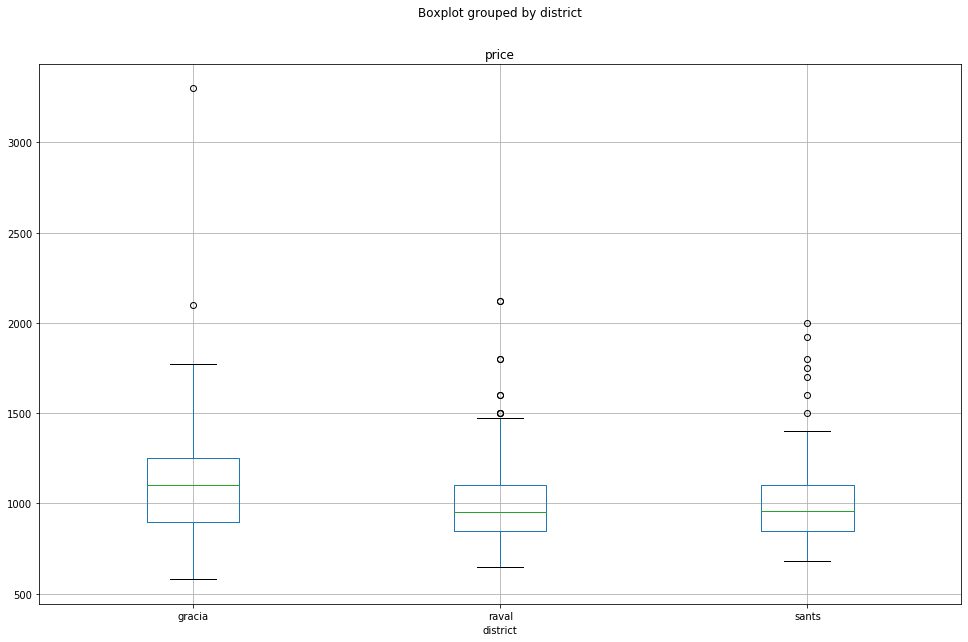

In [16]:
all_data[all_data.rooms == 1].boxplot("price", by="district")

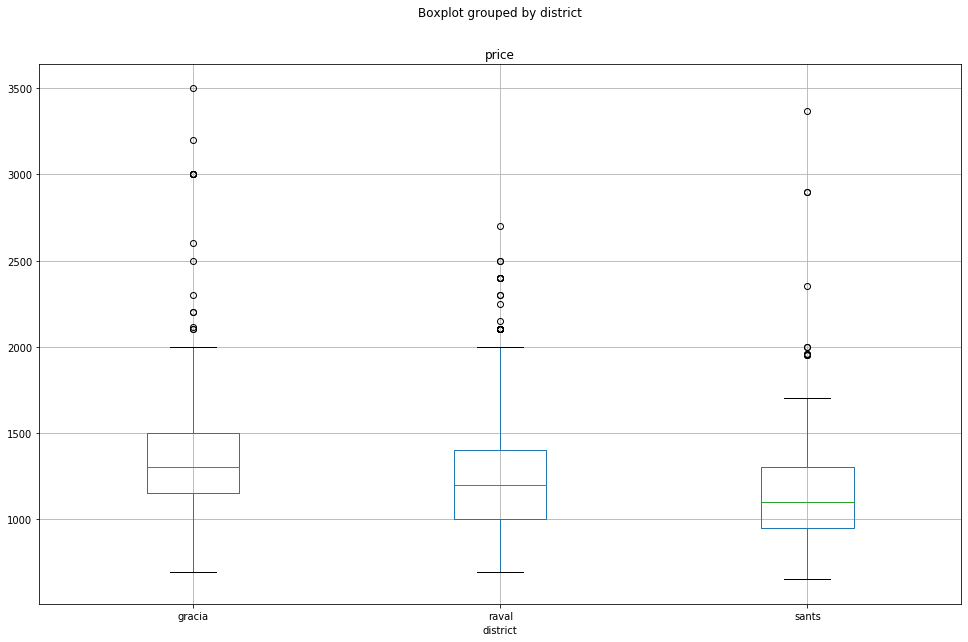

In [17]:
all_data[all_data.rooms == 2].boxplot("price", by="district")

In [18]:
all_data["url"] = all_data.join(all_raw, rsuffix="_raw")["url"].apply(lambda x: "https://idealista.com" + x)

In [19]:
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [20]:
all_data["price_per_square_foot"] = all_data["price"] / all_data["square_meterage"]

In [21]:
all_data[(all_data.district=='raval') &
         (all_data.rooms == 2) &
         (all_data.price < 1200)  
        ].sort_values("price_per_square_foot").style.format({'url': make_clickable})

,title,district,price,square_meterage,rooms,floor,url,price_per_square_foot
id,,,,,,,,
35341358,"Piso en calle de Sant Pau, El Raval, Barcelona",raval,1100,100,2,3,https://idealista.com/inmueble/35341358/,11
35985327,"Piso en calle dels Tallers, El Raval, Barcelona",raval,1150,101,2,3,https://idealista.com/inmueble/35985327/,11.3861
33570256,"Piso en hospital, El Raval, Barcelona",raval,950,82,2,2,https://idealista.com/inmueble/33570256/,11.5854
85376917,"Piso en Hospital, 114, El Raval, Barcelona",raval,950,82,2,4,https://idealista.com/inmueble/85376917/,11.5854
85872339,"Piso en calle Nou de la Rambla, El Raval, Barcelona",raval,1100,92,2,0,https://idealista.com/inmueble/85872339/,11.9565
86364780,"Piso en xuclà, El Raval, Barcelona",raval,1000,80,2,0,https://idealista.com/inmueble/86364780/,12.5
86286022,"Piso en calle del Pintor Fortuny, El Raval, Barcelona",raval,950,75,2,0,https://idealista.com/inmueble/86286022/,12.6667
85714278,"Piso en calle d'en Xuclà, 15, El Raval, Barcelona",raval,1100,85,2,1,https://idealista.com/inmueble/85714278/,12.9412
86030487,"Piso en calle Joaquín Costa, El Raval, Barcelona",raval,1175,90,2,1,https://idealista.com/inmueble/86030487/,13.0556


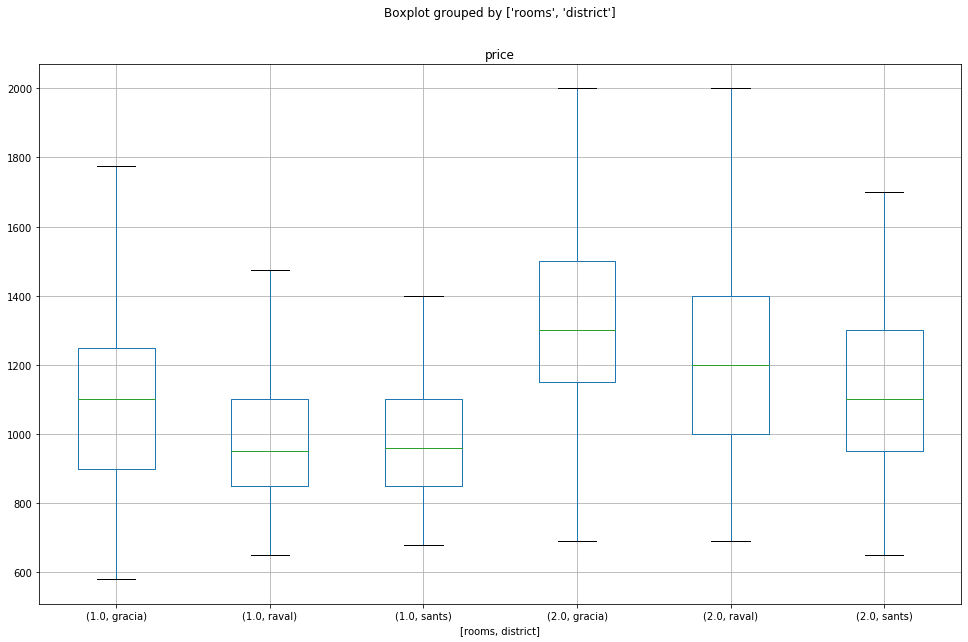

In [22]:
all_data[(all_data.rooms < 3)].boxplot("price", by=["rooms", "district"], showfliers=False)

In [23]:
poble_sec = all_data[all_data.title.str.contains("Poble Sec")]

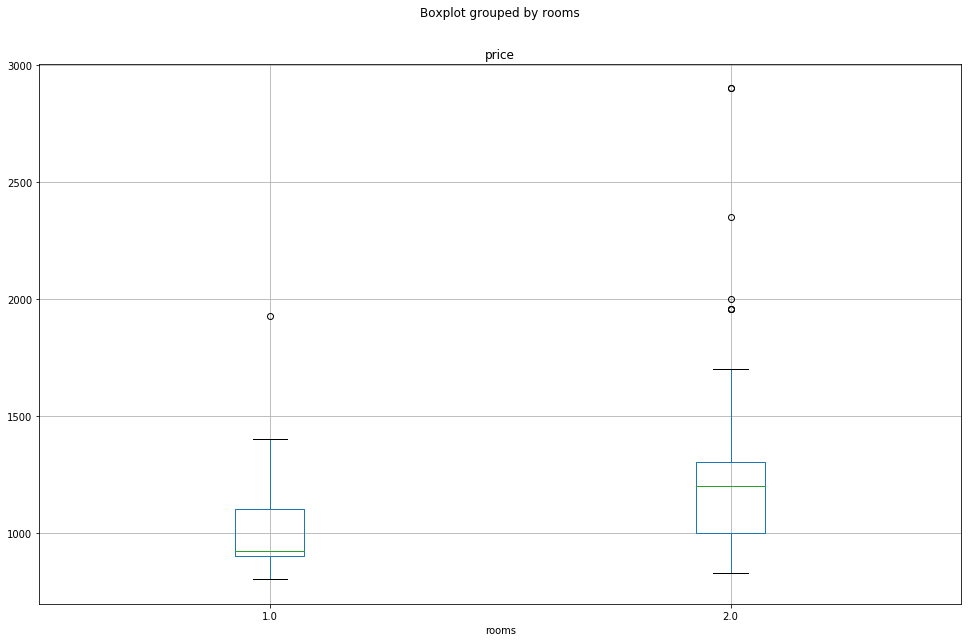

In [24]:
poble_sec[poble_sec.rooms < 3].boxplot("price", by="rooms")

In [25]:
poble_sec[(poble_sec.rooms == 1) & (poble_sec.price < 1200)].sort_values("square_meterage", ascending=False).style.format({'url': make_clickable})

,title,district,price,square_meterage,rooms,floor,url,price_per_square_foot
id,,,,,,,,
86428400,"Piso en calle d'Elkano, 4, El Poble Sec - Parc de Montjuïc, Barcelona",sants,850,65,1,2,https://idealista.com/inmueble/86428400/,13.0769
86414392,"Piso en Tapioles, El Poble Sec - Parc de Montjuïc, Barcelona",sants,900,65,1,nan,https://idealista.com/inmueble/86414392/,13.8462
86579051,"Piso en paseo de Montjuïc, El Poble Sec - Parc de Montjuïc, Barcelona",sants,1100,60,1,nan,https://idealista.com/inmueble/86579051/,18.3333
86437090,"Piso en calle del Roser, El Poble Sec - Parc de Montjuïc, Barcelona",sants,850,60,1,nan,https://idealista.com/inmueble/86437090/,14.1667
86567045,"Piso en calle del Roser, El Poble Sec - Parc de Montjuïc, Barcelona",sants,800,60,1,2,https://idealista.com/inmueble/86567045/,13.3333
86488932,"Piso en calle del Roser, El Poble Sec - Parc de Montjuïc, Barcelona",sants,850,60,1,2,https://idealista.com/inmueble/86488932/,14.1667
86398548,"Piso en calle del Roser, 72, El Poble Sec - Parc de Montjuïc, Barcelona",sants,850,60,1,2,https://idealista.com/inmueble/86398548/,14.1667
83533575,"Piso en Elkano, El Poble Sec - Parc de Montjuïc, Barcelona",sants,1100,60,1,2,https://idealista.com/inmueble/83533575/,18.3333
85548523,"Piso en Mata, El Poble Sec - Parc de Montjuïc, Barcelona",sants,1100,60,1,1,https://idealista.com/inmueble/85548523/,18.3333


In [26]:
all_data[
        ((all_data.rooms == 1) & (all_data.price < 1000)) |
        ((all_data.rooms == 2) & (all_data.price < 1200))
].sort_values("square_meterage", ascending=False).groupby(["district", "rooms"]).agg({"title": "count", "price": "median"})

#.style.format({'url': make_clickable})

title  price
district rooms              
gracia   1.0       47    900
         2.0       67   1025
raval    1.0      111    850
         2.0      102    990
sants    1.0       57    900
         2.0      105    950

In [27]:
all_data[
        (all_data.district == "raval") & (
            ((all_data.rooms == 1) & (all_data.price < 1000)) |
            ((all_data.rooms == 2) & (all_data.price < 1200))
        )
].sort_values("square_meterage", ascending=False).style.format({'url': make_clickable})

,title,district,price,square_meterage,rooms,floor,url,price_per_square_foot
id,,,,,,,,
35985327,"Piso en calle dels Tallers, El Raval, Barcelona",raval,1150,101,2,3,https://idealista.com/inmueble/35985327/,11.3861
35341358,"Piso en calle de Sant Pau, El Raval, Barcelona",raval,1100,100,2,3,https://idealista.com/inmueble/35341358/,11
85872339,"Piso en calle Nou de la Rambla, El Raval, Barcelona",raval,1100,92,2,0,https://idealista.com/inmueble/85872339/,11.9565
86030487,"Piso en calle Joaquín Costa, El Raval, Barcelona",raval,1175,90,2,1,https://idealista.com/inmueble/86030487/,13.0556
85714278,"Piso en calle d'en Xuclà, 15, El Raval, Barcelona",raval,1100,85,2,1,https://idealista.com/inmueble/85714278/,12.9412
85376917,"Piso en Hospital, 114, El Raval, Barcelona",raval,950,82,2,4,https://idealista.com/inmueble/85376917/,11.5854
33570256,"Piso en hospital, El Raval, Barcelona",raval,950,82,2,2,https://idealista.com/inmueble/33570256/,11.5854
35474902,"Piso en calle de Joaquín Costa, El Raval, Barcelona",raval,1150,81,2,2,https://idealista.com/inmueble/35474902/,14.1975
86364780,"Piso en xuclà, El Raval, Barcelona",raval,1000,80,2,0,https://idealista.com/inmueble/86364780/,12.5


In [28]:
F, p_anova = ss.f_oneway(*[all_data[all_data.district == d]["price"] for d in {"gracia", "sants", "raval"}])

In [29]:
p_anova

2.5735915665567968e-09

In [30]:
H, p_kruskal = ss.kruskal(*[all_data[all_data.district == d]["price"] for d in {"gracia", "sants", "raval"}])

In [31]:
p_kruskal

2.049593568284428e-13

In [183]:
regression_data = all_data[
    all_data.rooms.isin([1,2])
]

In [184]:
X = pd.get_dummies(regression_data[["district", "square_meterage", "rooms", "floor"]]).fillna(0)
y = regression_data[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [185]:
def show_regression_results(model):
    y_hat_train = model.predict(X_train)
    print("In-sample MSE: %0.02f" % mean_squared_error(y_train, y_hat_train))
    print("In-sample r^2: %0.02f" % r2_score(y_train, y_hat_train))
    y_hat_test = model.predict(X_test)
    print("Out-of-sample MSE: %0.02f" % mean_squared_error(y_test, y_hat_test))
    print("Out-of-sample r^2: %0.02f" % r2_score(y_test, y_hat_test))
    coeffs = dict(zip(X.columns, model.coef_.reshape(-1)))
    print("Intercept: %0.02f" % model.intercept_)
    print("Coefficients:")
    for (key, coeff) in coeffs.items():
        print("\t - %s - %0.02f" % (key, coeff))
    c = model.intercept_
    cmap = plt.get_cmap('tab10')
    plt.figure()
    for (i, key) in enumerate(coeffs):
        plt.subplot(3, 2, i+1)
        m = coeffs[key]
        x = X[key]
        plt.scatter(x, y, color=cmap.colors[i])
        x_hat = np.arange(0, x.max() + 1)
        plt.plot(x_hat, m*x_hat+c, color=cmap.colors[i])
        plt.title(key)
    plt.show()

In-sample MSE: 116169.86
In-sample r^2: 0.28
Out-of-sample MSE: 93592.51
Out-of-sample r^2: 0.35
Intercept: 462.11
Coefficients:
	 - square_meterage - 8.84
	 - rooms - 104.68
	 - floor - 7.49
	 - district_gracia - 69.15
	 - district_raval - -11.93
	 - district_sants - -59.96


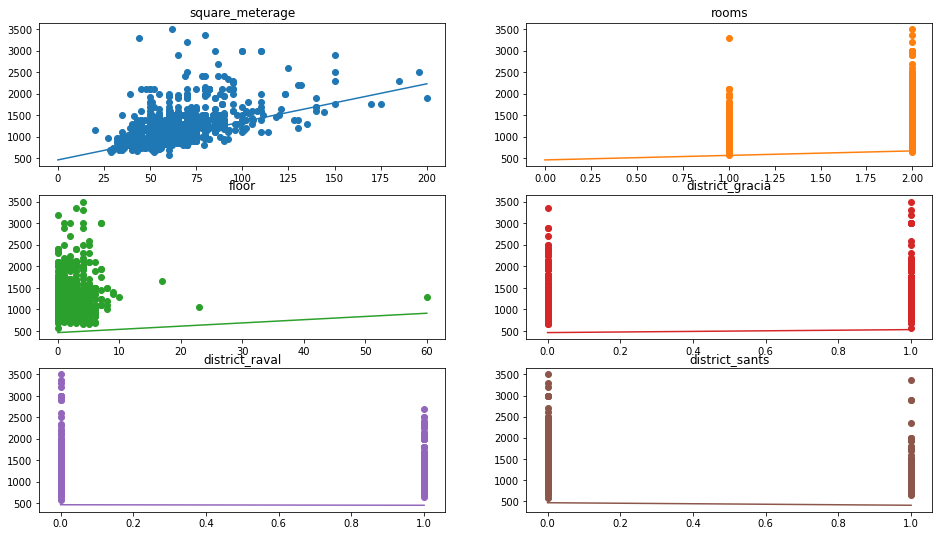

In [186]:
lreg = LinearRegression(normalize=True)
lreg.fit(X_train, y_train)
show_regression_results(lreg)

/Users/tim/src/barcelona_research/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In-sample MSE: 118559.16
In-sample r^2: 0.26
Out-of-sample MSE: 93044.78
Out-of-sample r^2: 0.35
Intercept: 287.92
Coefficients:
	 - square_meterage - 9.27
	 - rooms - 100.11
	 - floor - 12.05
	 - district_gracia - 144.89
	 - district_raval - 99.23
	 - district_sants - 43.81


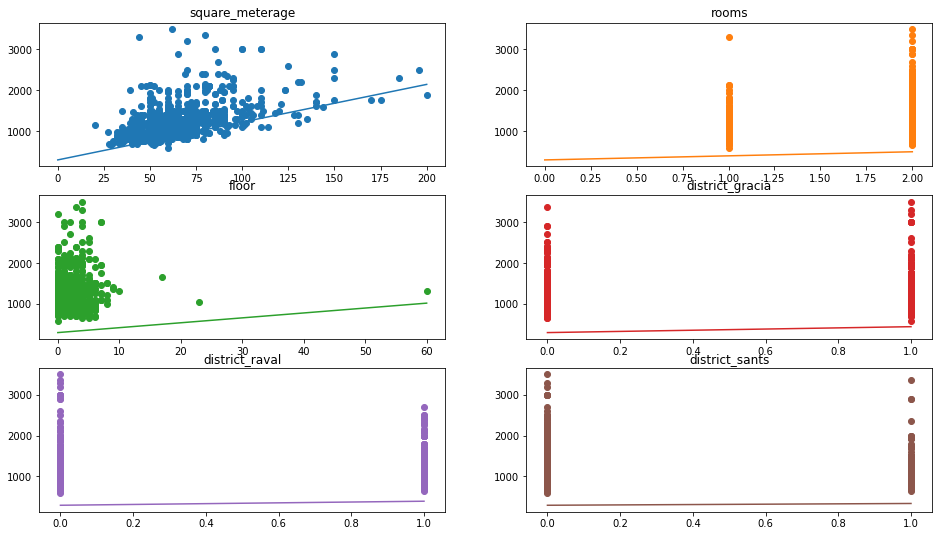

In [187]:
tsreg = TheilSenRegressor()
tsreg.fit(X_train, y_train)
show_regression_results(tsreg)

,title,district,price,square_meterage,rooms,floor,url,price_per_square_foot
id,,,,,,,,
39308830,"Piso en Sugranyes, Sants - Badal, Barcelona",sants,1400,100,6.0,1.0,https://idealista.com/inmueble/39308830/,14.0
